# MT Data-conditioned VAE

In [574]:
# pip install tensorflow

In [575]:
%load_ext autoreload
%autoreload 2

import os
import time
import gc
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import scipy as sp
from scipy import interpolate
# import scipy.interpolate

from cgnn import cvae_mt64_updated as vae

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [576]:
run = 's4'
if not os.path.exists(run):
    os.makedirs(run)

# Set up survey

In [577]:
def import_file(file):
    with open(file, 'r') as f:
        reader = csv.reader(f)
        data = list(reader)
    line = np.array(data, dtype=float)
    cond = line[:,25:55]
    obs_xs = line[:,270:285]
    print(obs_xs.shape)
    obs_zs = -line[:,286:301]
    print(obs_zs.shape)
    obs_total = np.concatenate((obs_xs, obs_zs), axis=1)
    print(obs_total.shape)
    pred_zs = line[:,348:363]
    return line,cond, obs_total, pred_zs

In [578]:
line1,cond1, obs1, pred1 = import_file('Line1_Central-Copy1.csv')
line2,cond2, obs2, pred2 = import_file('Line2_Central-Copy1.csv')
line3,cond3, obs3, pred3 = import_file('Line3_Central-Copy1.csv')

print(obs1)

(16258, 15)
(16258, 15)
(16258, 30)
(3355, 15)
(3355, 15)
(3355, 30)
(17419, 15)
(17419, 15)
(17419, 30)
[[6.295087 5.203734 4.723107 ... 0.976215 0.582863 0.272842]
 [6.274186 5.188221 4.709166 ... 0.971868 0.579572 0.271219]
 [6.262685 5.180632 4.702812 ... 0.96766  0.576283 0.269532]
 ...
 [6.030007 5.631565 5.39819  ... 1.78922  1.159736 0.554354]
 [5.965578 5.573674 5.343903 ... 1.782502 1.155238 0.552165]
 [5.912551 5.526641 5.300363 ... 1.777644 1.151855 0.550477]]


In [579]:
print(len(cond1[:,0]))

16258


In [580]:
np.save('Line1_Central.npy', line1)
# np.save('Line1_Central_Conductivity.npy',cond1)
np.save('Line1_Central_Observations.npy',obs1)

In [581]:
np.save('Line2_Central.npy', line2)
# np.save('Line2_Central_Conductivity.npy',cond2)
np.save('Line2_Central_Observations.npy',obs2)

In [582]:
np.save('Line3_Central.npy', line3)
# np.save('Line3_Central_Conductivity.npy',cond3)
np.save('Line3_Central_Observations.npy',obs3)

In [583]:
data1 = np.load('Line1_Central.npy')
np.load('Line1_Central_Observations.npy')

array([[6.295087, 5.203734, 4.723107, ..., 0.976215, 0.582863, 0.272842],
       [6.274186, 5.188221, 4.709166, ..., 0.971868, 0.579572, 0.271219],
       [6.262685, 5.180632, 4.702812, ..., 0.96766 , 0.576283, 0.269532],
       ...,
       [6.030007, 5.631565, 5.39819 , ..., 1.78922 , 1.159736, 0.554354],
       [5.965578, 5.573674, 5.343903, ..., 1.782502, 1.155238, 0.552165],
       [5.912551, 5.526641, 5.300363, ..., 1.777644, 1.151855, 0.550477]])

In [584]:
data2 = np.load('Line2_Central.npy')
np.load('Line2_Central_Conductivity.npy')

array([[0.03648398, 0.04375333, 0.06125686, ..., 0.001001  , 0.00100172,
        0.00100138],
       [0.03692505, 0.04404815, 0.06117529, ..., 0.00100094, 0.00100167,
        0.00100133],
       [0.0355793 , 0.04299819, 0.06089889, ..., 0.00100111, 0.00100183,
        0.00100149],
       ...,
       [0.00886633, 0.01143951, 0.02004766, ..., 0.00100052, 0.00100119,
        0.00100088],
       [0.00974181, 0.01277133, 0.02308966, ..., 0.0010005 , 0.00100116,
        0.00100085],
       [0.01089706, 0.01448192, 0.02690818, ..., 0.00100052, 0.00100117,
        0.00100087]])

In [585]:
data3 = np.load('Line3_Central.npy')
np.load('Line3_Central_Conductivity.npy')

array([[0.04755097, 0.07919228, 0.2120686 , ..., 0.00100109, 0.00100129,
        0.0010012 ],
       [0.0492395 , 0.08198991, 0.2180947 , ..., 0.00100109, 0.00100129,
        0.00100119],
       [0.05325513, 0.08775873, 0.2287608 , ..., 0.00100107, 0.00100127,
        0.00100118],
       ...,
       [0.013676  , 0.01695183, 0.02671344, ..., 0.00100166, 0.00100244,
        0.00100208],
       [0.01278256, 0.01582356, 0.02485566, ..., 0.00100166, 0.00100244,
        0.00100208],
       [0.01163806, 0.01427949, 0.02214111, ..., 0.00100167, 0.00100249,
        0.0010021 ]])

In [586]:
print(len(cond1[0]))

30


In [587]:
# remote reference frequencies
#   7.680002e+02   5.120000e+02   3.840000e+02   2.560000e+02   1.920000e+02   1.280000e+02
#   9.599997e+01   6.400000e+01   4.800001e+01   3.200000e+01   2.400000e+01   1.600000e+01
#   1.200000e+01   8.000000e+00   5.999999e+00   4.000000e+00   3.000000e+00   2.000000e+00
#   1.500000e+00   1.000000e+00   7.500002e-01   5.000000e-01   3.750000e-01   2.500000e-01
#   1.875000e-01


# mesh
# 64 ft
cell_size = 32*0.3048
depth_to_top = 32*0.3048
n_cells = 32
# one fewer depth; last cell extends to inf
#depths = depth_to_top + np.arange(1,n_cells)*cell_size
#depths to bottom
depths = np.array([4,8.4,13.24,18.56,24.42,30.86,37.95,45.74,54.31,63.74,74.11,85.52,98.07,111.88,127.07,143.78,162.16,182.38,204.62,229.08,255.99,285.59,318.15,353.97,393.37,436.71,484.38,536.82,594.5])
n_depths = len(depths)
print(n_depths)
# data frequencies
# conservative, lines up with remote referenced stations, minus one frequency to avoid extrapolation
f_a = np.logspace(-2, 9, num=12, base=2)
f_b = np.logspace(-4, 7, num=12, base=2)*3
times = np.array([0.013,0.039,0.065,0.104,0.169,0.273,0.443,0.703,1.094,1.693,2.63,4.102,6.406,9.961,16.055,16.055])
# frequencies = np.logspace(-4, 10, 15, base=2)
nt = len(times)
print(nt)
# data are only real
ndata = nt

29
16


In [588]:
depth = np.append(0,depths)
# print(depth)
cond1_new = np.zeros((len(cond1[:,0]),32))
for i in range(len(cond1[:,0])):
    x = cond1[i]
    y = depth
    f = sp.interpolate.interp1d(y,x)
    y_new = [554,573]
    x_new = f(y_new)
    cond1_new[i] = np.append(x,x_new)
    y = np.append(y_new,depths)
    y.sort()

cond2_new = np.zeros((len(cond2[:,0]),32))
for i in range(len(cond2[:,0])):
    x = cond2[i]
    y = depth
    f = sp.interpolate.interp1d(y,x)
    y_new = [554,573]
    x_new = f(y_new)
    cond2_new[i] = np.append(x,x_new)
    y = np.append(y_new,depths)
    y.sort()

cond3_new = np.zeros((len(cond3[:,0]),32))
for i in range(len(cond3[:,0])):
    x = cond3[i]
    y = depth
    f = sp.interpolate.interp1d(y,x)
    y_new = [554,573]
    x_new = f(y_new)
    cond3_new[i] = np.append(x,x_new)
    y = np.append(y_new,depths)
    y.sort()

obs1_new = np.zeros((len(obs1[:,0]),32))
for i in range(len(obs1[:,0])):
    x = obs1[i]
    y = depth
    f = sp.interpolate.interp1d(y,x)
    y_new = [554,573]
    x_new = f(y_new)
    obs1_new[i] = np.append(x,x_new)
    y = np.append(y_new,depths)
    y.sort()

obs2_new = np.zeros((len(obs2[:,0]),32))
for i in range(len(obs2[:,0])):
    x = obs2[i]
    y = depth
    f = sp.interpolate.interp1d(y,x)
    y_new = [554,573]
    x_new = f(y_new)
    obs2_new[i] = np.append(x,x_new)
    y = np.append(y_new,depths)
    y.sort()

obs3_new = np.zeros((len(obs3[:,0]),32))
for i in range(len(obs1[:,0])):
    x = obs3[i]
    y = depth
    f = sp.interpolate.interp1d(y,x)
    y_new = [554,573]
    x_new = f(y_new)
    obs3_new[i] = np.append(x,x_new)
    y = np.append(y_new,depths)
    y.sort()
    
# print(len(cond1_new[0]))
# print(cond1_new[1])
depths=y
print(depths)
print(obs1_new.shape)


[  4.     8.4   13.24  18.56  24.42  30.86  37.95  45.74  54.31  63.74
  74.11  85.52  98.07 111.88 127.07 143.78 162.16 182.38 204.62 229.08
 255.99 285.59 318.15 353.97 393.37 436.71 484.38 536.82 554.   573.
 594.5 ]
(16258, 32)


In [589]:
np.save('Line1_Central_Conductivity.npy',cond1_new)
np.save('Line2_Central_Conductivity.npy',cond2_new)
np.save('Line3_Central_Conductivity.npy',cond3_new)

np.save('Line1_Central_Observations.npy',obs1_new)
np.save('Line2_Central_Observations.npy',obs2_new)
np.save('Line3_Central_Observations.npy',obs3_new)

In [590]:
# x = np.arange(depths.size)
# new_length = 63
# new_x = np.linspace(x.min(), x.max(), new_length)
# new_depths = sp.interpolate.interp1d(x, depths)(new_x)
# print(new_depths)
# print(len(new_depths))
# depths = new_depths

# Load training models and Create neural network

In [591]:
# normalize model parameters between -1 and 1
# remember, min resistivity is 0.01, max is 1e5
# Gaussian infill potentially allows for values outside this range, but not likely
min_model = np.log(1e-5)
max_model = np.log(1e5)
# pad by norm_pad, so that a bunch of values don't end up at -1
norm_pad = 0.1

# create network
network = vae.CVAE(depths,
                   min_model=min_model,
                   max_model=max_model,
                   times = times,
                   norm_pad=norm_pad,
                   data_std=0.1,
                   model_std=.01,
                   beta_vae=4,
                   model_loss_type='ae',
                   data_loss_type='se'
                  )

thicknesses (31,)


c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [592]:
# Due to ranging orders of magnitude - recommended to keep
def preprocess(filename):
    '''
    Read RILD values from npy file
    Convert to log conductivity
    Reshape to include channel dimension
    '''
    x = np.log(1/np.load(filename))
    x = x.reshape(-1, n_cells, 1)
    return x

x_train_log = preprocess('Line1_Central_Conductivity.npy')
x_validate_log = preprocess('Line3_Central_Conductivity.npy')
x_test1_log = preprocess('Line2_Central_Conductivity.npy')
# x_test2_log = preprocess('KGS_RILD_64ft_test2.npy')
# print(x_train_log)

x_train_raw_log = preprocess('Line1_Central_Observations.npy')
x_validate_raw_log = preprocess('Line3_Central_Observations.npy')
x_test1_raw_log = preprocess('Line2_Central_Observations.npy')
#print(x_train_raw_log)

x_train_raw = network.model_to_tanhs(x_train_raw_log)
x_validate_raw = network.model_to_tanhs(x_validate_raw_log)
x_test1_raw = network.model_to_tanhs(x_test1_raw_log)
# print(x_train_raw)

x_train = network.model_to_tanhs(x_train_log)
x_validate = network.model_to_tanhs(x_validate_log)
x_test1 = network.model_to_tanhs(x_test1_log)
# x_test2 = network.model_to_tanhs(x_test2_log)
print(x_train)
print(np.max(x_train))

[[[ 0.3717506 ]
  [ 0.35877268]
  [ 0.33019401]
  ...
  [ 0.5399025 ]
  [ 0.53984124]
  [ 0.53986997]]

 [[ 0.35924058]
  [ 0.3459848 ]
  [ 0.3168738 ]
  ...
  [ 0.53991749]
  [ 0.53985802]
  [ 0.53988592]]

 [[ 0.34984667]
  [ 0.33582953]
  [ 0.30524038]
  ...
  [ 0.53992124]
  [ 0.53986095]
  [ 0.53988923]]

 ...

 [[-0.06332845]
  [-0.10986223]
  [-0.13967353]
  ...
  [ 0.53997866]
  [ 0.53995864]
  [ 0.53996803]]

 [[-0.06540916]
  [-0.10690175]
  [-0.13454177]
  ...
  [ 0.53997788]
  [ 0.53995752]
  [ 0.53996707]]

 [[-0.0760605 ]
  [-0.10976947]
  [-0.12975373]
  ...
  [ 0.53997772]
  [ 0.5399577 ]
  [ 0.53996709]]]
0.5400728129689761


C:\Users\saraf\AppData\Local\Temp\ipykernel_9220\1457260169.py:8: RuntimeWarning: divide by zero encountered in divide
  x = np.log(1/np.load(filename))


In [593]:
x_train1 = x_train[0:100,]
x_validate1 = x_validate[0:100,]
x_train_raw1 = x_train_raw[0:100,]
x_validate_raw1 = x_validate_raw[0:100,]
x_test_raw1 = x_test1_raw[0:100,]
print(x_train1.T[0,].shape)

(32, 100)


In [594]:
# compute stds
model_std = np.std(x_train.flatten())
#mt_data_file = 'KGS_MT.npy'
#os.remove(mt_data_file)
#try:
#    all_data = tf.convert_to_tensor(np.load(mt_data_file))
#except FileNotFoundError:
#    all_data = network.predict_tanh(x_train)
#    np.save(mt_data_file, all_data.numpy())
train_data = network.predict_tanh(x_train1)
# print(train_data)
print("train data", train_data[...,1:])
print('.........')
raw_train_data = network.predict_tanh(x_train_raw1)
# log_train_data = tf.math.log(-train_data)
#print('log_train_data'log_train_data.shape)
print("raw_train_data", raw_train_data)

validate_data = network.predict_tanh(x_validate1)
raw_validate_data = network.predict_tanh(x_validate_raw1)

# test1_data = network.predict_tanh(x_test1)
# log_test1_data = tf.math.log(-test1_data)

# test2_data = network.predict_tanh(x_test2)
# log_test2_data = tf.math.log(-test2_data)

tanhs (100, 32, 1)
ys (100, 32)
ys_test (100,)
train data tf.Tensor(
[[ 4.4400925e-13  2.9181456e-13  1.6861276e-13 ... -6.0870215e-18
  -2.1737461e-18 -2.1737461e-18]
 [ 4.8334394e-13  2.9928666e-13  1.6121577e-13 ... -6.0796017e-18
  -2.1805970e-18 -2.1805970e-18]
 [ 5.1536358e-13  3.0183660e-13  1.5270547e-13 ... -6.0629051e-18
  -2.1809155e-18 -2.1809155e-18]
 ...
 [ 5.1240430e-13  1.3951249e-13  3.7317863e-14 ... -6.9424400e-18
  -2.5074684e-18 -2.5074684e-18]
 [ 4.9317191e-13  1.2872636e-13  3.3956619e-14 ... -6.9364628e-18
  -2.5058471e-18 -2.5058471e-18]
 [ 4.6514973e-13  1.1511011e-13  3.0105787e-14 ... -7.0201776e-18
  -2.5351574e-18 -2.5351574e-18]], shape=(100, 31), dtype=float32)
.........
tanhs (100, 32, 1)
ys (100, 32)
ys_test (100,)
raw_train_data tf.Tensor(
[[-6.5048070e-13  1.2369248e-13  4.8920239e-14 ... -1.0933522e-19
  -2.3536206e-20 -2.3536206e-20]
 [-6.4954796e-13  1.2382074e-13  4.8649087e-14 ... -1.0975757e-19
  -2.3650889e-20 -2.3650889e-20]
 [-6.4830259e-13 

In [595]:
# np.save('train_data.npy',train_data)
# np.save('raw_train_data.npy',raw_train_data)
# np.save('validate_data.npy',validate_data)
# np.save('raw_validate_data.npy',raw_validate_data)

In [596]:
# train_data = np.load('train_data.npy')
# raw_train_data = np.load('raw_train_data.npy')
# validate_data = np.load('validate_data.npy')
# raw_validate_data = np.load('raw_validate_data.npy')

In [597]:
# # Create batches and shuffle
BATCH_SIZE = 75

#x_train1 = models *log transform models*; log_train_data: raw data

train_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(x_train1, tf.float32), 
    tf.cast(raw_train_data, tf.float32))).shuffle(10000).batch(BATCH_SIZE)

validate_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(x_validate1, tf.float32),
    tf.cast(raw_validate_data, tf.float32))).shuffle(10000).batch(x_validate1.shape[0])

# though the data vary over several orders of magnitude, 
# they don't vary so much within one frequency.
# data_std_vec = np.std(train_data.numpy(), axis=0)
# log_data_std_vec = np.std(log_train_data.numpy(), axis=0)
# log_data_std = np.std(log_train_data.numpy().flatten())
# average_log_data_std = np.std((log_train_data.numpy() - log_train_data.numpy().mean(axis=0)).flatten())
# print(model_std, log_data_std, average_log_data_std)
# compute elementwise stds
model_std_vec = np.std(x_train1, axis=0)
model_std_vec = np.reshape(model_std_vec, (n_cells))
# # compute relative std
mean_train_data = np.mean(train_data, axis=0)
rel_data_std = np.abs(mean_train_data)

# same for model, but mean over all
mean_model_value = np.mean(x_train1)
rel_model_std = 0.5*mean_model_value
print(mean_model_value, rel_model_std)

0.3091059569838888 0.1545529784919444


In [598]:
# finalize network
network = vae.CVAE(depths,
                   min_model=min_model,
                   max_model=max_model,
                   times=times,
                   norm_pad=norm_pad,
                   data_std=rel_data_std.reshape(1, -1, 1),
#                    model_std=model_std,
                   model_std=model_std_vec.reshape(1, -1, 1),
                   latent_dim=20,
                   beta_vae=4,
                   model_loss_type='se',
                   data_loss_type='se'
                  )

# double check forward model
'''

all_data[0, 0], all_data[0, 24]

network.predict_tanh(x_train[0:1])

c60 = np.load('KSG_RILD_60ft.npy')
c60[0].shape

vae.forward_1_freq(c60[200], depths, frequencies[0])[0]

vae.forward_1_freq(c60[200], depths, frequencies[-1])[0]

all_data.numpy().max(), all_data.numpy().min()

all_data.shape

'''

#for i_freq in range(nf):
#    plt.hist(all_data.numpy()[:, i_freq].flatten(), bins=50)

thicknesses (31,)


"\n\nall_data[0, 0], all_data[0, 24]\n\nnetwork.predict_tanh(x_train[0:1])\n\nc60 = np.load('KSG_RILD_60ft.npy')\nc60[0].shape\n\nvae.forward_1_freq(c60[200], depths, frequencies[0])[0]\n\nvae.forward_1_freq(c60[200], depths, frequencies[-1])[0]\n\nall_data.numpy().max(), all_data.numpy().min()\n\nall_data.shape\n\n"

In [599]:
# May be able to remove/adjust steps since I have data instead of models
i_random_train = np.arange(16)
# random_train = x_train[i_random_train].reshape((16, n_cells))
# pick some random training models
# i_random_train = np.random.randint(0, x_train1.shape[0], 16)
#i_random_train = np.arange(16)
random_train = x_train1[i_random_train].reshape((16, n_cells))
print('i_random_train',i_random_train)
print('random_train',random_train)
# predict their data
random_data = network.predict_tanh(random_train.reshape(16, n_cells, 1))
print('n_cells',n_cells)
random_log_data = tf.math.log(-random_data)
print('random_log_data', random_log_data)
print('random_data',random_data)
# Save data and latent space inputs for plots
# print(network.latent_dim)
latent_input = tf.random.normal([16, network.latent_dim], seed=0, dtype=tf.float32)
# print(latent_input)
print('n_data',network.n_data)
data_input = tf.reshape(random_data,(16,network.n_data))
print('data_input',data_input)
zd_input = tf.concat((latent_input,data_input),axis=-1)
print('zd_input',zd_input)
# Why are there nan values????? The forward modelling produces (16,30) arrays which should fit perfectly into data_input
#

i_random_train [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
random_train [[ 3.71750602e-01  3.58772676e-01  3.30194010e-01  2.82490024e-01
   2.12936612e-01  1.27888156e-01  6.02049786e-02  3.49576498e-02
   4.40362114e-02  6.53828532e-02  7.59341185e-02  6.06357791e-02
   1.76675995e-02  4.19611529e-03  7.98784278e-02  1.83823370e-01
   2.79550958e-01  3.57563413e-01  4.17262398e-01  4.60768152e-01
   4.91039839e-01  5.11126956e-01  5.23797698e-01  5.31371287e-01
   5.35645945e-01  5.37917092e-01  5.39050902e-01  5.39582423e-01
   5.39815261e-01  5.39902501e-01  5.39841235e-01  5.39869971e-01]
 [ 3.59240576e-01  3.45984796e-01  3.16873801e-01  2.68490179e-01
   1.98700643e-01  1.15832258e-01  5.35029192e-02  3.38021340e-02
   4.67337210e-02  6.72045859e-02  7.43442646e-02  5.62247407e-02
   1.44325321e-02  7.50414536e-03  8.70015047e-02  1.90955564e-01
   2.85389842e-01  3.61932776e-01  4.20348794e-01  4.62848687e-01
   4.92383918e-01  5.11960888e-01  5.24296035e-01  5.31659321e-

In [600]:
# plot a few random training models and their data
# vae.plot_complex(random_data, times=times, save2file=True, filename=run+'/training_MT_data.png')
vae.plot_logs(np.exp(network.tanhs_to_model(random_train)), depths=depths, save2file=True, 
              filename=run + '/training_models.png')

# Save starting plots
network.plot_models(save2file=True,folder=run,samples=zd_input.shape[0],
                    latent=zd_input,step=0)
# network.plot_data(save2file=True,folder=run,latent=zd_input,step=0)
# network.plot_residuals(save2file=True,folder=run,latent=zd_input,step=0)

plt.close('all')
plt.clf()
gc.collect()

(16, 32, 1)


152386

<Figure size 640x480 with 0 Axes>

In [601]:
optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

# Train

In [602]:
epochs = 10

In [603]:
validate_terms = []
train_terms = []
train_losses = []
ttest_losses = []
# print(len(train_dataset))
for epoch in range(1, epochs + 1):
    start_time = time.time()
#     print(train_dataset)
#     print(optimizer)
    for train_x in train_dataset:#.batch(BATCH_SIZE):
        # print(len(train_x[1]))
        if len(train_x[1]) == 80:
            train_loss, train_term = vae.compute_apply_gradients(network, train_x, optimizer, 
                                    use_data_misfit=True)
        #train_losses.append(train_loss.numpy())
            train_terms.append([tt.numpy() for tt in train_term])
        else:
            continue
#         for test_x in test_dataset:
#             ttest_loss = vae.compute_losses(network, test_x)
#             terms = [loss(l).numpy() for l in ttest_loss]
#             ttest_losses.append(terms)
    end_time = time.time()

    # compute and save losses
    for val_x in validate_dataset:#.batch(BATCH_SIZE):
        val_loss, val_term = vae.compute_loss(network, val_x)
        #terms = [tf.reduce_mean(l).numpy() for l in losses]
        #loss(vae.compute_reconstruction_loss(network, test_x))
    #elbo = -loss.result()
    validate_terms.append([tt.numpy() for tt in val_term])
    print('Epoch: {}, Data misfit: {:.4}, '
          'Reconstruction: {:.4}, '
          'KL: {:.4}, '
          'Elapsed {:.4} s'.format(epoch, val_term[0], val_term[1], val_term[2],
                                #elbo,
                                end_time - start_time))
        
    if epoch % 1e3 == 0:
        network.plot_models(save2file=True,folder=run,samples=zd_input.shape[0],
                 latent=zd_input,step=epoch)
        network.plot_data(save2file=True,folder=run,latent=zd_input,step=epoch)
        network.plot_residuals(save2file=True,folder=run,latent=zd_input,step=epoch)
        plt.close('all')
        gc.collect()

network.inference_net.save(run+'/encoder.h5')
network.generative_net.save(run+'/decoder.h5')
#np.save(run+'/optimizer_weights.npy', optimizer.load_weights())
np.save(run+'/losses.npy', np.array(validate_terms))
np.save(run+'/train_losses.npy', np.array(train_terms))
# WHERE IS THE 35 COMING FROM????n

d_input: Tensor("xy_1:0", shape=(100, 32), dtype=float32)
zd: Tensor("concat:0", shape=(100, 52), dtype=float32)
tanhs (100, 32, 1)
ys <unknown>
ys_test <unknown>
Epoch: 1, Data misfit: inf, Reconstruction: 1.088e+09, KL: 0.07769, Elapsed 0.01455 s
Epoch: 2, Data misfit: inf, Reconstruction: 1.083e+09, KL: -0.049, Elapsed 0.01045 s
Epoch: 3, Data misfit: inf, Reconstruction: 1.093e+09, KL: 0.04099, Elapsed 0.009008 s
Epoch: 4, Data misfit: inf, Reconstruction: 1.09e+09, KL: -0.00576, Elapsed 0.01 s
Epoch: 5, Data misfit: inf, Reconstruction: 1.091e+09, KL: 0.163, Elapsed 0.009398 s
Epoch: 6, Data misfit: inf, Reconstruction: 1.085e+09, KL: -0.1141, Elapsed 0.01149 s
Epoch: 7, Data misfit: inf, Reconstruction: 1.087e+09, KL: 0.1353, Elapsed 0.008999 s
Epoch: 8, Data misfit: inf, Reconstruction: 1.087e+09, KL: 0.1898, Elapsed 0.01667 s
Epoch: 9, Data misfit: inf, Reconstruction: 1.088e+09, KL: -0.01886, Elapsed 0.00785 s
Epoch: 10, Data misfit: inf, Reconstruction: 1.089e+09, KL: -0.0041

c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [604]:
network.plot_models(save2file=True,folder=run,samples=zd_input.shape[0],
         latent=zd_input,step=epoch)

(16, 32, 1)


In [605]:
network.plot_data(save2file=True,folder=run,latent=zd_input,step=epoch)

d_obs tf.Tensor(
[[ 6.23714899e-11 -8.14143631e-12 -4.45883478e-12 -2.21306935e-12
  -8.40448425e-13 -2.44495206e-13 -5.23489604e-14 -9.47507318e-15
  -1.73424840e-15 -3.99860379e-16 -1.21620101e-16 -4.26845313e-17
  -1.58558595e-17 -6.08702154e-18 -2.17374607e-18 -2.17374607e-18]
 [ 6.80868834e-11 -9.95676892e-12 -5.19682995e-12 -2.36698291e-12
  -8.11656677e-13 -2.11847182e-13 -4.08528531e-14 -6.98433426e-15
  -1.34557367e-15 -3.50895574e-16 -1.15315026e-16 -4.17375816e-17
  -1.57209646e-17 -6.07960173e-18 -2.18059699e-18 -2.18059699e-18]
 [ 7.33622468e-11 -1.17951048e-11 -5.81258782e-12 -2.45157085e-12
  -7.69135732e-13 -1.83161537e-13 -3.25696670e-14 -5.44478708e-15
  -1.13031211e-15 -3.23866356e-16 -1.11385481e-16 -4.10578310e-17
  -1.56025123e-17 -6.06290509e-18 -2.18091545e-18 -2.18091545e-18]
 [ 8.04244310e-11 -1.41891845e-11 -6.45129566e-12 -2.47851110e-12
  -6.99946069e-13 -1.50138799e-13 -2.46543644e-14 -4.17872354e-15
  -9.71344773e-16 -3.04714226e-16 -1.08820705e-16 -4.075

In [606]:
# something weird here
network.plot_residuals(save2file=True,folder=run,latent=zd_input,step=epoch,weighted=False)

tanhs (16, 32, 1)
ys (16, 32)
ys_test (16,)
d_res (16, 32)
d_res tf.Tensor(
[[-2.95839503e-12 -3.21530237e-13 -2.59667206e-13 -1.58392437e-13
  -7.50116386e-14 -2.82627451e-14 -8.52788536e-15 -2.52555558e-15
  -9.24609307e-16 -4.44137808e-16 -2.46859653e-16 -1.43563522e-16
  -8.45148497e-17 -4.98401763e-17 -2.77106581e-17 -2.77106581e-17
  -2.83340226e-11 -8.45478201e-13 -3.23515325e-12 -1.97487469e-12
  -7.95219739e-13 -2.35775944e-13 -5.06896872e-14 -9.13166400e-15
  -1.65793359e-15 -3.82573469e-16 -1.17766127e-16 -4.18409163e-17
  -1.56729616e-17 -6.04697814e-18 -2.16605391e-18 -2.16605391e-18]
 [-2.79176205e-12 -3.44943095e-13 -2.67212766e-13 -1.51527730e-13
  -6.56597782e-14 -2.26488377e-14 -6.43912795e-15 -1.96507747e-15
  -8.02210769e-16 -4.18838152e-16 -2.41202823e-16 -1.42358048e-16
  -8.44205048e-17 -4.99792717e-17 -2.78497683e-17 -2.78497683e-17
  -3.74168682e-11 -9.47772243e-13 -3.87133381e-12 -2.14155972e-12
  -7.69712744e-13 -2.03085189e-13 -3.90242072e-14 -6.58277838e-15

In [607]:
plt.close('all')
plt.clf()
gc.collect()

22787

<Figure size 640x480 with 0 Axes>

# Load networks

In [608]:
network.inference_net = tf.keras.models.load_model(run+'/encoder.h5')
network.generative_net = tf.keras.models.load_model(run+'/decoder.h5')

In [609]:
loss_terms = np.load(run+'/losses.npy')

In [610]:
#optimizer_weights = np.load(run+'/optimizer_weights.npy', allow_pickle=True)

https://stackoverflow.com/questions/49503748/save-and-load-model-optimizer-state to train more

# Plot loss over epochs

In [611]:
plt.rcParams.update({'font.size': 18})

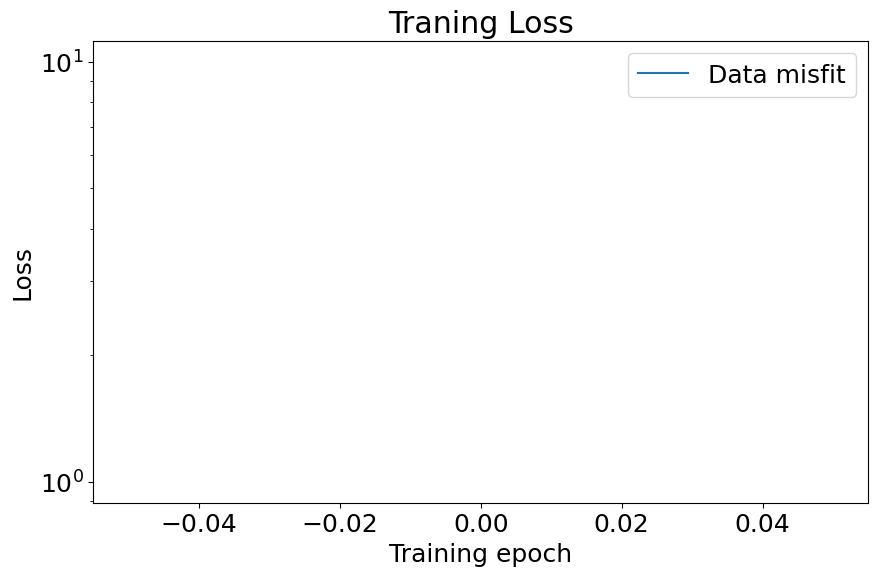

In [612]:
tt = np.array(train_terms)
batches_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_batches = tt.shape[0]
plt.figure(figsize=(10,6))
plt.semilogy(np.arange(num_batches)/batches_per_epoch, tt)
plt.ylabel('Loss')
plt.xlabel('Training epoch')
plt.title("Traning Loss")
plt.legend(['Data misfit', 'Reconstruction error', 'KL divergence'])
plt.savefig('training_loss_'+run+'_w.png')
plt.show()

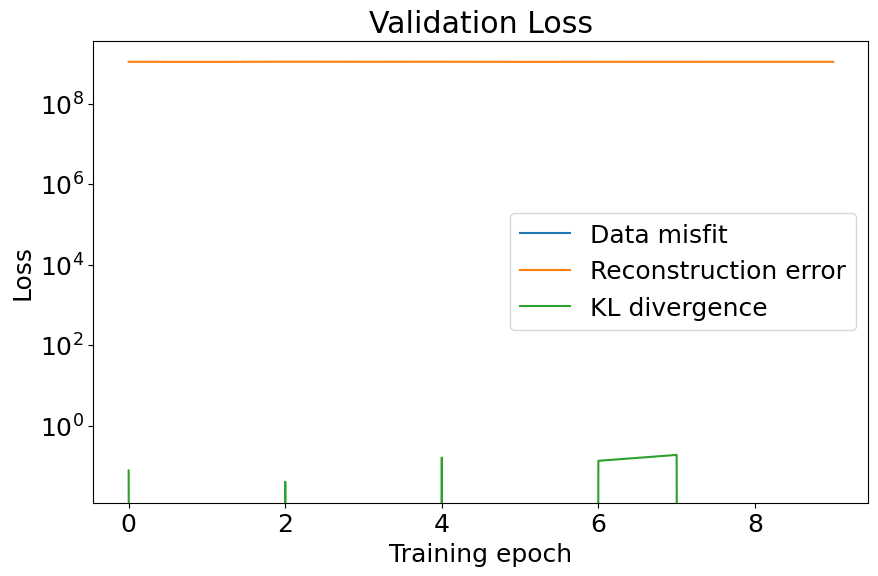

In [613]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(epochs),validate_terms)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Training epoch')
plt.title('Validation Loss')
plt.legend(['Data misfit', 'Reconstruction error', 'KL divergence'])
plt.savefig('validation_loss_'+run+'_w.png')
plt.show()

# View some tests

In [614]:
vae.plot_logs(np.exp(network.tanhs_to_model(x_validate[0:16])), depths=depths, step=16, save2file=True)

In [615]:
z_model = network.reparameterize(*network.encode(x_validate[0:16]))
z_data = raw_validate_data[0:16]
zmd = tf.concat((z_model,z_data),-1)
print(zmd)
network.plot_models(latent=zmd)

tf.Tensor(
[[-1.01222444e+00 -8.83897662e-01  1.05447972e+00  8.86856377e-01
  -1.59993052e+00  2.66169965e-01  1.43705034e+00 -4.51987982e-01
  -1.29893005e+00  1.57680380e+00  9.48406607e-02  1.52100909e+00
   6.38092935e-01  3.23001921e-01 -1.02671698e-01 -4.40543175e-01
   3.25720876e-01 -7.04641521e-01 -6.82294145e-02 -1.23163447e-01
  -4.88533476e-13  9.31213385e-14  2.24674032e-14  5.78216369e-15
   1.51911971e-15  4.90390042e-16  1.84643905e-16  7.66732569e-17
   3.28603719e-17  1.39001961e-17  5.66738537e-18  2.22397661e-18
   8.46064112e-19  3.16824107e-19  1.06830227e-19  1.06830227e-19
   3.98075080e-11 -6.44238005e-12 -9.89125448e-13 -1.59815534e-13
  -2.31750806e-14 -3.86395805e-15 -8.03430126e-16 -2.07032905e-16
  -5.82640546e-17 -1.64427872e-17 -4.46273370e-18 -1.15876475e-18
  -2.90290557e-19 -7.16114102e-20 -1.53341934e-20 -1.53341934e-20]
 [-8.20704877e-01 -1.33270144e-01 -7.20733464e-01 -9.08951998e-01
   1.37484282e-01  5.85853279e-01  2.07161114e-01  6.72784150e-0

In [616]:
def minmax(x): return tf.reduce_min(x), tf.reduce_max(x)

In [617]:
tanhs = network.decode(zmd, apply_tanh=True)
minmax(tanhs)

(<tf.Tensor: shape=(), dtype=float32, numpy=-0.11922945>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.11345621>)

In [618]:
minmax(x_test1[0:16])

(<tf.Tensor: shape=(), dtype=float64, numpy=-0.03254183984457575>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.5399266299885006>)

In [619]:
network.plot_data(latent=zmd)

d_obs tf.Tensor(
[[ 3.9807508e-11 -6.4423800e-12 -9.8912545e-13 -1.5981553e-13
  -2.3175081e-14 -3.8639581e-15 -8.0343013e-16 -2.0703290e-16
  -5.8264055e-17 -1.6442787e-17 -4.4627337e-18 -1.1587647e-18
  -2.9029056e-19 -7.1611410e-20 -1.5334193e-20 -1.5334193e-20]
 [ 3.9767665e-11 -6.4496086e-12 -9.9512423e-13 -1.6130233e-13
  -2.3417156e-14 -3.8969983e-15 -8.0836859e-16 -2.0815632e-16
  -5.8592717e-17 -1.6544016e-17 -4.4928753e-18 -1.1672750e-18
  -2.9257929e-19 -7.2209462e-20 -1.5468032e-20 -1.5468032e-20]
 [ 3.9745103e-11 -6.4567219e-12 -1.0005331e-12 -1.6264626e-13
  -2.3636963e-14 -3.9272162e-15 -8.1300642e-16 -2.0925742e-16
  -5.8926117e-17 -1.6649055e-17 -4.5246205e-18 -1.1763286e-18
  -2.9503113e-19 -7.2853299e-20 -1.5612617e-20 -1.5612617e-20]
 [ 3.9747840e-11 -6.4634405e-12 -1.0048881e-12 -1.6373175e-13
  -2.3815803e-14 -3.9521681e-15 -8.1704999e-16 -2.1029358e-16
  -5.9257115e-17 -1.6756765e-17 -4.5578347e-18 -1.1859259e-18
  -2.9765337e-19 -7.3546128e-20 -1.5768895e-20 -1.

tanhs (16, 32, 1)
ys (16, 32)
ys_test (16,)
d_res (16, 32)
d_res tf.Tensor(
[[-2.54030629e-13 -2.04313834e-14 -6.42180401e-15 -3.54687085e-15
  -1.51305389e-15 -5.10929427e-16 -1.37183352e-16 -3.03325807e-17
  -3.90053378e-18 -1.22420994e-18 -1.36652181e-18 -7.86117919e-19
  -3.68721962e-19 -1.57284102e-19 -5.84505466e-20 -5.84505466e-20
  -4.91085957e-11 -2.14496259e-12 -1.18616597e-13 -5.02572837e-14
  -1.81329341e-14 -4.66152597e-15 -9.15161713e-16 -1.58589449e-16
  -2.33399465e-17 -1.87873397e-18 -4.39877693e-19 -2.93152964e-19
  -1.05692253e-19 -3.17822922e-20 -7.81419915e-21 -7.81419915e-21]
 [-3.65733810e-13 -4.07405026e-14 -1.10892740e-14 -4.90004452e-15
  -1.98738112e-15 -7.13438646e-16 -2.15897343e-16 -5.71840214e-17
  -1.20872528e-17 -9.56771690e-19 -8.89377150e-19 -7.15068481e-19
  -3.71672205e-19 -1.65760326e-19 -6.30032841e-20 -6.30032841e-20
  -5.62258053e-11 -3.69035228e-12 -3.17331990e-13 -8.22091283e-14
  -2.33849110e-14 -5.99107632e-15 -1.29527685e-15 -2.54655003e-16

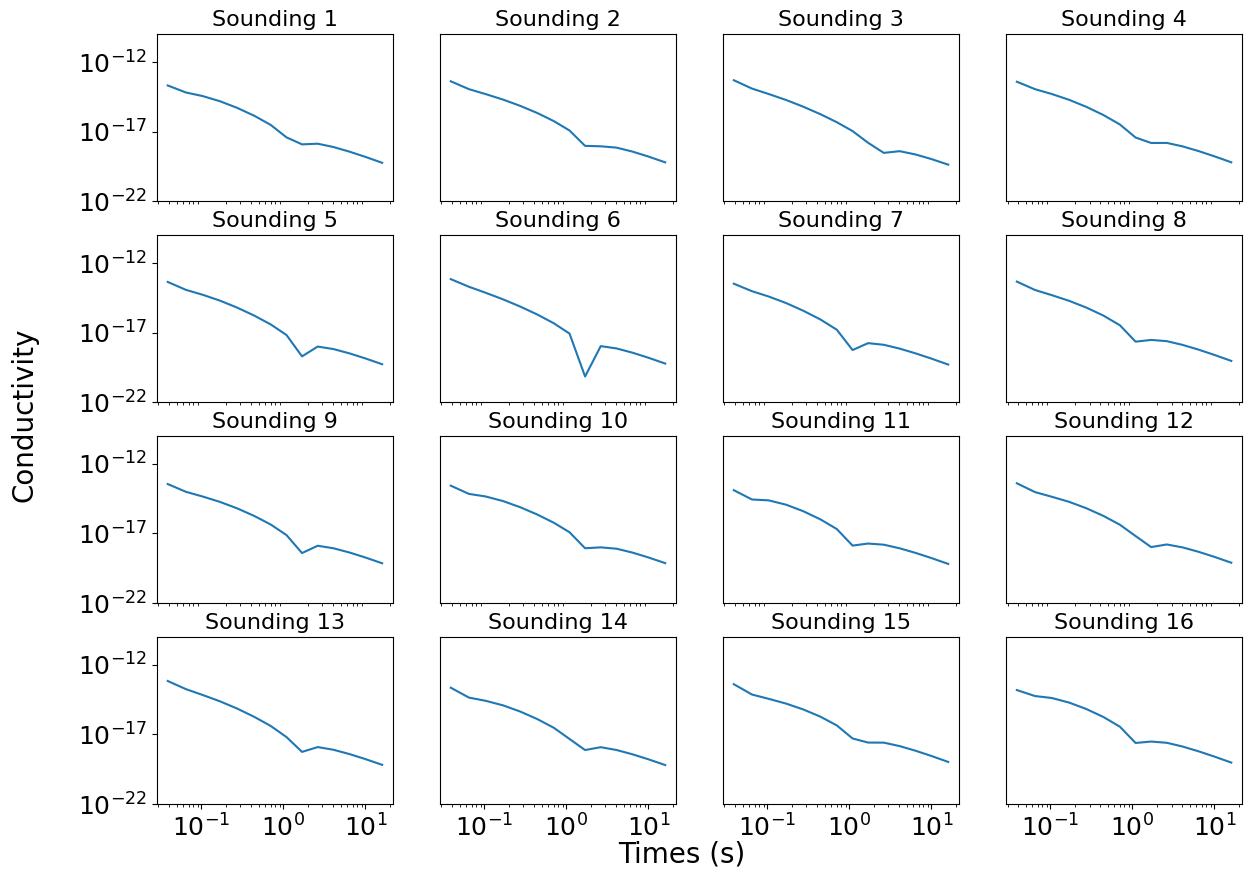

In [620]:
network.plot_residuals(latent=zmd, ylims=(1e-22, 1e-10), weighted=False)

# Randomize latent; does data still fit?

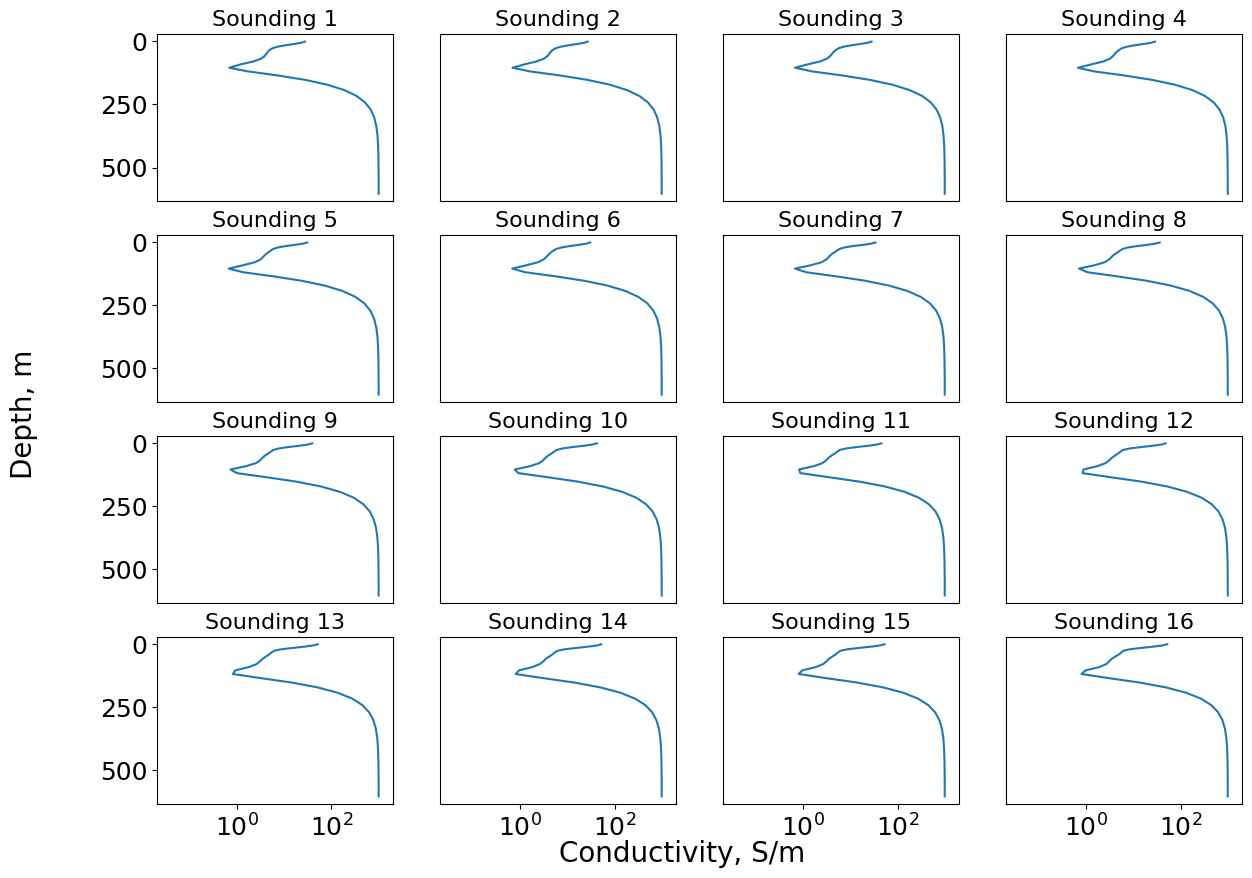

In [621]:
vae.plot_logs(np.exp(network.tanhs_to_model(x_test1[0:16])), depths=depths)

In [622]:
print(x_test1[0:1].shape)

(1, 32, 1)


In [623]:
data0 = tf.tile(z_data[0:1],[16,1])
zmd2 = tf.concat((latent_input,data0),-1)

In [624]:
network.plot_models(latent=zmd2)

(16, 32, 1)


In [625]:
zmd2_tanhs = network.decode(zmd2, apply_tanh=True)
zmd2_samples = zmd2_tanhs.shape[0]
zmd2_tanhs = np.reshape(zmd2_tanhs, (zmd2_samples, network.n_model))
zmd2_logs = np.exp(network.tanhs_to_model(zmd2_tanhs))

In [626]:
zmd2_logs.shape

(16, 32)

In [627]:
depth_centers = (network.depths[1:] + network.depths[:-1])/2
plot_depths = np.r_[
    depth_centers[0] - (depth_centers[1] - depth_centers[0]),
    depth_centers,
    depth_centers[-1] + depth_centers[-1] - depth_centers[-2]
]

In [628]:
# print(zmd2_logs)
mean_cond = np.mean((zmd2_logs),axis=0)
std_cond = np.std((zmd2_logs),axis=0)
uncertainty = np.mean(mean_cond+std_cond**2)
print(uncertainty)
# plt.semilogx(mean_cond, plot_depths)
# plt.invert_yaxis()

1.1245134


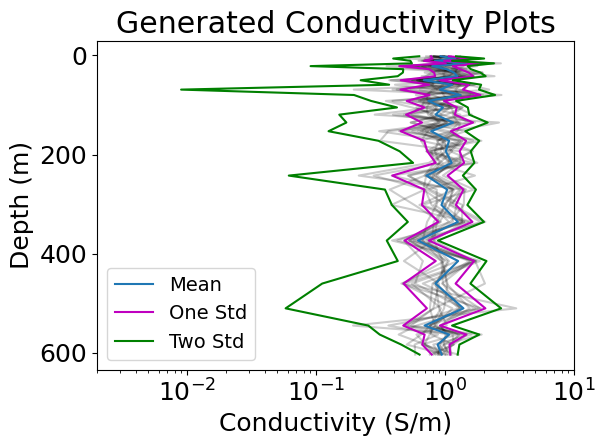

In [629]:
fig, ax = plt.subplots()
for log in zmd2_logs:
    ax.semilogx(log, plot_depths, c='k', alpha=0.2)
ax.semilogx(mean_cond, plot_depths,label='Mean')
ax.semilogx(np.abs(mean_cond+std_cond),plot_depths, c='m', label="One Std")
ax.semilogx(np.abs(mean_cond-std_cond), plot_depths, c='m')
ax.semilogx(np.abs(mean_cond+2*std_cond), plot_depths, c='g', label= 'Two Std') # type: ignore
ax.semilogx(np.abs(mean_cond-2*std_cond), plot_depths, c='g')
# ax.semilogx(mean_cond+std_cond**2, plot_depths)
ax.invert_yaxis()
ax.axes.set_xlabel("Conductivity (S/m)")
ax.axes.set_ylabel("Depth (m)")
ax.axes.set_xlim(2e-3, 1e1)
ax.axes.set_title('Generated Conductivity Plots')
ax.axes.legend(fontsize=14)

plt.tight_layout()
plt.savefig('Preliminary_generated_plots_mean&2std.jpg')
plt.show()

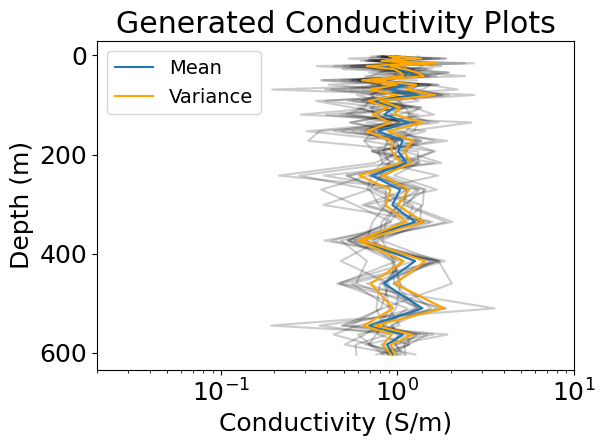

In [630]:
fig, ax = plt.subplots()
for log in zmd2_logs:
    if len(log) != len(plot_depths):
        log = np.delete(log, [-2,-1])
    ax.semilogx(log, plot_depths, c='k', alpha=0.2)
ax.semilogx(mean_cond, plot_depths,label='Mean')
ax.semilogx(np.abs(mean_cond+std_cond**2), plot_depths, c='orange', label='Variance')
ax.semilogx(np.abs(mean_cond-std_cond**2), plot_depths, c='orange')
ax.invert_yaxis()
ax.axes.set_xlabel("Conductivity (S/m)")
ax.axes.set_ylabel("Depth (m)")
ax.axes.set_xlim(2e-2, 1e1)
ax.axes.set_title('Generated Conductivity Plots')
ax.axes.legend(fontsize=14)

plt.tight_layout()
plt.savefig('Preliminary_generated_plots.jpg')
plt.show()

In [631]:
network.plot_data(latent=zmd2)

d_obs tf.Tensor(
[[ 3.9807508e-11 -6.4423800e-12 -9.8912545e-13 -1.5981553e-13
  -2.3175081e-14 -3.8639581e-15 -8.0343013e-16 -2.0703290e-16
  -5.8264055e-17 -1.6442787e-17 -4.4627337e-18 -1.1587647e-18
  -2.9029056e-19 -7.1611410e-20 -1.5334193e-20 -1.5334193e-20]
 [ 3.9807508e-11 -6.4423800e-12 -9.8912545e-13 -1.5981553e-13
  -2.3175081e-14 -3.8639581e-15 -8.0343013e-16 -2.0703290e-16
  -5.8264055e-17 -1.6442787e-17 -4.4627337e-18 -1.1587647e-18
  -2.9029056e-19 -7.1611410e-20 -1.5334193e-20 -1.5334193e-20]
 [ 3.9807508e-11 -6.4423800e-12 -9.8912545e-13 -1.5981553e-13
  -2.3175081e-14 -3.8639581e-15 -8.0343013e-16 -2.0703290e-16
  -5.8264055e-17 -1.6442787e-17 -4.4627337e-18 -1.1587647e-18
  -2.9029056e-19 -7.1611410e-20 -1.5334193e-20 -1.5334193e-20]
 [ 3.9807508e-11 -6.4423800e-12 -9.8912545e-13 -1.5981553e-13
  -2.3175081e-14 -3.8639581e-15 -8.0343013e-16 -2.0703290e-16
  -5.8264055e-17 -1.6442787e-17 -4.4627337e-18 -1.1587647e-18
  -2.9029056e-19 -7.1611410e-20 -1.5334193e-20 -1.

In [632]:
#log_data_test[0]

In [633]:
-tf.exp(zmd2[0, 50:])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-1., -1.], dtype=float32)>

In [634]:
# network.predict_tanh(network.decode(zmd2, apply_tanh=True))[0]

tanhs (16, 32, 1)
ys (16, 32)
ys_test (16,)
d_res (16, 32)
d_res tf.Tensor(
[[-7.69109159e-25 -1.28094217e-26 -1.34669457e-27 -2.12397236e-28
  -2.58925994e-29 -2.83725648e-30 -2.94353754e-31 -3.00788345e-32
  -1.36075116e-33 -7.78175515e-34 -3.96634845e-34 -1.29349711e-34
  -3.53761897e-35 -8.83121915e-36 -1.80766802e-36 -1.80766802e-36
  -7.57672076e-21 -6.42652478e-23 -1.14022882e-24 -8.28716685e-26
  -4.65055652e-27 -2.02947251e-28 -7.48636805e-30 -3.21398094e-31
  -1.43425387e-32 -2.51447815e-34 -7.01582668e-35 -1.41616606e-35
  -1.88651633e-36 -2.18259635e-37 -1.90694707e-38 -1.90694707e-38]
 [-1.03874137e-24 -1.97564837e-26 -1.33647771e-27 -1.86923225e-28
  -2.55406417e-29 -3.28285555e-30 -4.08433741e-31 -5.48648470e-32
  -6.76769493e-33 -3.81582915e-34 -1.57531671e-34 -8.18007635e-35
  -2.61162616e-35 -7.02932779e-36 -1.50599810e-36 -1.50599810e-36
  -9.77959967e-21 -1.12697199e-22 -1.63517100e-24 -6.93681324e-26
  -3.95789196e-27 -2.04733575e-28 -8.96794383e-30 -4.58431935e-31

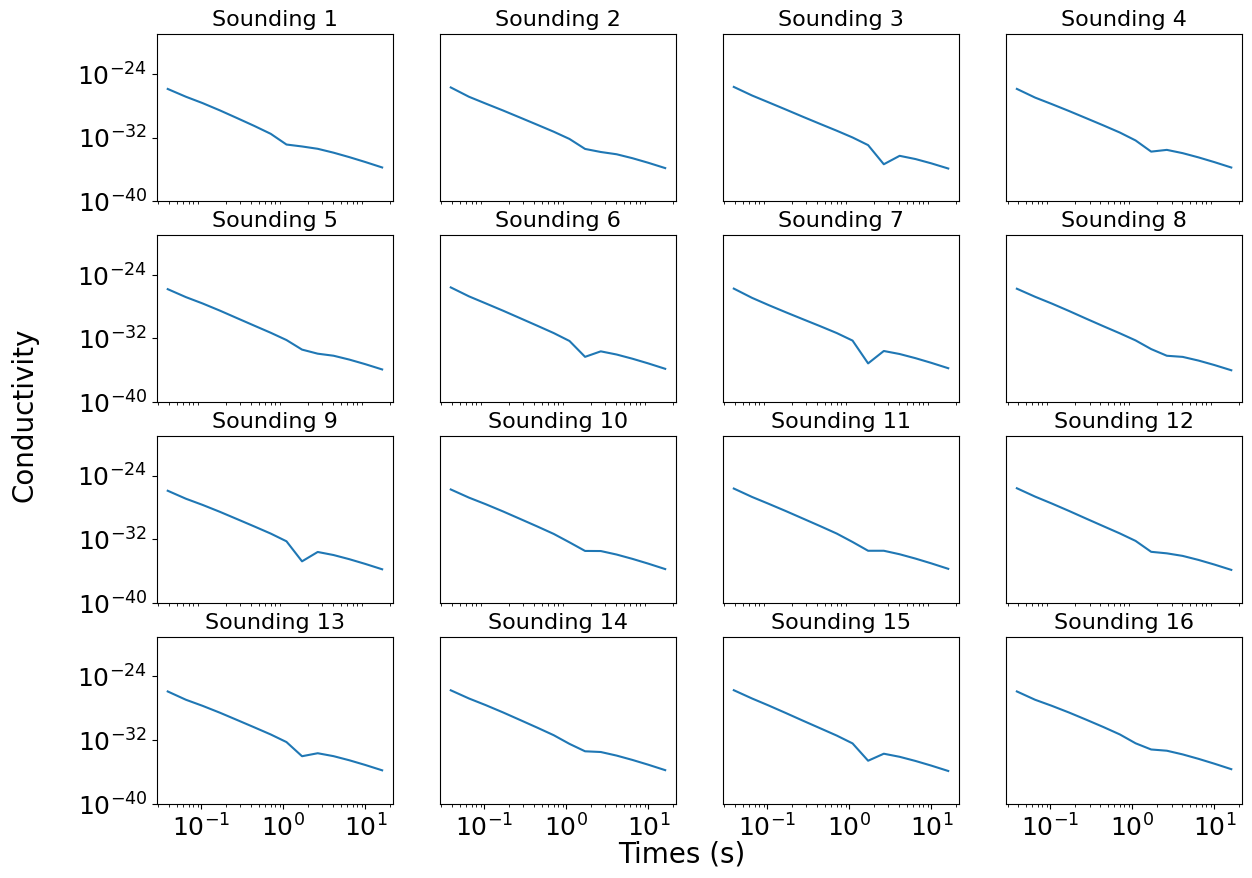

In [635]:
network.plot_residuals(latent=zmd2, ylims=(1e-40, 1e-19), weighted=True)

In [636]:
y_true = [[0., 0.], 
          [0., 0.]]
y_pred = [[3., 0.], 
          [2., 0.]]
# Using 'auto'/'sum_over_batch_size' reduction type.
# Using 'none' reduction type.
mse = tf.keras.losses.MeanSquaredError(
    reduction=tf.keras.losses.Reduction.NONE)
# Calling with 'sample_weight'.
mse(y_true, y_pred, sample_weight=[0.7, 0.3]).numpy()


array([3.1499999, 0.6      ], dtype=float32)

In [637]:
1/2*((3-0)**2 + 0**2)*.7, 1/2*((2-0)**2 + (0-0)**2)*.3

(3.15, 0.6)

In [638]:
network.data_weights

array([[[4.70466308e+24],
        [1.68086898e+26],
        [1.65332176e+27],
        [1.39720114e+28],
        [1.26443582e+29],
        [9.62829173e+29],
        [5.35927636e+30],
        [2.00571867e+31],
        [5.99466564e+31],
        [1.64976787e+32],
        [4.47805660e+32],
        [1.23182144e+33],
        [3.44769303e+33],
        [9.82557466e+33],
        [3.19348693e+34],
        [3.19348693e+34],
        [1.44407218e+21],
        [5.01665510e+22],
        [1.35412692e+24],
        [2.86245898e+25],
        [7.19612725e+26],
        [1.83153938e+28],
        [4.18210849e+29],
        [5.76158874e+30],
        [5.06862653e+31],
        [3.60626054e+32],
        [2.40928308e+33],
        [1.58473322e+34],
        [1.03701128e+35],
        [6.69423464e+35],
        [5.13904349e+36],
        [5.13904349e+36]]], dtype=float32)

In [639]:
print(cond2[0])
print(cond2[1])

[3.648398e-02 4.375333e-02 6.125686e-02 9.333318e-02 1.370639e-01
 1.768252e-01 2.043877e-01 2.243076e-01 2.409013e-01 2.620672e-01
 3.102367e-01 4.454715e-01 8.480549e-01 1.465697e+00 5.938051e-01
 1.385875e-01 3.616845e-02 1.220992e-02 5.347820e-03 2.938946e-03
 1.941052e-03 1.475557e-03 1.242081e-03 1.121129e-03 1.058532e-03
 1.026996e-03 1.011817e-03 1.004928e-03 1.002029e-03 1.001002e-03]
[3.692505e-02 4.404815e-02 6.117529e-02 9.257349e-02 1.356392e-01
 1.754015e-01 2.036590e-01 2.246761e-01 2.426639e-01 2.649555e-01
 3.129994e-01 4.433329e-01 8.184385e-01 1.454583e+00 6.258761e-01
 1.456389e-01 3.750132e-02 1.251276e-02 5.433118e-03 2.967756e-03
 1.952150e-03 1.480173e-03 1.244037e-03 1.121919e-03 1.058802e-03
 1.027046e-03 1.011785e-03 1.004876e-03 1.001975e-03 1.000939e-03]


In [640]:
# num_plots = 4
# fig = plt.figure(figsize=(8, 10))
# for i in range(0, num_plots):
#     ax = plt.subplot(int(num_plots),2,i+1)
#     ax.plot(times, -obs2[i], -pred2[i])
#     plt.xlabel('Time (s)')
#     plt.ylabel('dB/dt')
#     plt.legend(['Observed','Predicted'])
# plt.tight_layout()
# plt.savefig('Raw_Time_Decay_Curves_Line2_Central.jpg')

In [641]:
# print(len(cond2))

In [642]:
# depths1 = np.append(depths,[652])
# fig, ax = plt.subplots()
# ax.semilogx(cond2[0], depths1, c='k', alpha=0.2)
# ax.semilogx(cond1[0], depths1, c='k',alpha=0.2)
# ax.invert_yaxis()
# # ax.axes.set_xlim(1e-2, 1e4)
# plt.xlabel('Conductivity')
# plt.ylabel('Depth')
# plt.tight_layout()
# plt.savefig('Raw_ConductivityvsDepth_Line2_Central.jpg')
# plt.show()